In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_parquet("C:\\Users\\Tobi\\Desktop\\New folder\\git\\Energy_Load_Profile_Classification\\Energy_Load_Profile_Classification\\main.parquet")

In [3]:
df = df[['Time','system_kW']]

In [4]:
df['Time'] = pd.to_datetime(df['Time'])

In [5]:
# df['new_date'] = [d.date() for d in df['Time']]
# df['new_time'] = [d.time() for d in df['Time']]

In [6]:
# import pandas as pd

# # Get week number, with pd.DateOffset used to start the week on Sunday
# week_date_values = df["Time"].dt.isocalendar()
# df["week_date"] = (df['Time'] - pd.to_timedelta(df['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# # Combine with "(week n)" values
# df["week_date"] = df["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
# df

### taking the max, min and mean by hour distance

In [7]:
# data re-sampled based on an hour
df_by_hr_max = df.resample('H', on='Time').system_kW.max()

df_by_hr_max = pd.DataFrame(df_by_hr_max).reset_index()

df_by_hr_max.rename(columns = {'system_kW':'Max_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_max["Time"].dt.isocalendar()
df_by_hr_max["week_date"] = (df_by_hr_max['Time'] - pd.to_timedelta(df_by_hr_max['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_max["week_date"] = df_by_hr_max["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
df_by_hr_max

# data re-sampled based on an hour
df_by_hr_min = df.resample('H', on='Time').system_kW.min()

df_by_hr_min = pd.DataFrame(df_by_hr_min).reset_index()

df_by_hr_min.rename(columns = {'system_kW':'Min_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_min["Time"].dt.isocalendar()
df_by_hr_min["week_date"] = (df_by_hr_min['Time'] - pd.to_timedelta(df_by_hr_min['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_min["week_date"] = df_by_hr_min["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
Min_Load = df_by_hr_min.Min_Load.to_list()

# data re-sampled based on an hour
df_by_hr_mean = df.resample('H', on='Time').system_kW.mean()

df_by_hr_mean = pd.DataFrame(df_by_hr_mean).reset_index()

df_by_hr_mean.rename(columns = {'system_kW':'Mean_Load'}, inplace = True)

import pandas as pd

# Get week number, with pd.DateOffset used to start the week on Sunday
week_date_values = df_by_hr_mean["Time"].dt.isocalendar()
df_by_hr_mean["week_date"] = (df_by_hr_mean['Time'] - pd.to_timedelta(df_by_hr_mean['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# Combine with "(week n)" values
df_by_hr_mean["week_date"] = df_by_hr_mean["week_date"] + " " + "(week " + week_date_values["week"].astype(str) + ")"
Mean_Load = df_by_hr_mean.Mean_Load.to_list()

df_max_min_mean = df_by_hr_max.assign(Min_Load=Min_Load,Mean_Load=Mean_Load)

df_hr_max_min_mean = df_max_min_mean[['Time','week_date','Max_Load','Min_Load','Mean_Load']]

df_hr_max_min_mean

,Time,week_date,Max_Load,Min_Load,Mean_Load
0,2022-09-17 12:00:00,2022-09-11 (week 37),46.666,29.376,37.835000
1,2022-09-17 13:00:00,2022-09-11 (week 37),51.045,31.066,43.259552
2,2022-09-17 14:00:00,2022-09-11 (week 37),45.432,35.635,40.673883
3,2022-09-17 15:00:00,2022-09-11 (week 37),47.489,36.948,43.198733
4,2022-09-17 16:00:00,2022-09-11 (week 37),59.146,36.043,46.881117
...,...,...,...,...,...
3271,2023-01-31 19:00:00,2023-01-29 (week 5),87.146,72.626,79.960733
3272,2023-01-31 20:00:00,2023-01-29 (week 5),82.882,70.813,77.210667
3273,2023-01-31 21:00:00,2023-01-29 (week 5),76.380,57.502,66.348317
3274,2023-01-31 22:00:00,2023-01-29 (week 5),62.340,52.269,57.426000


### Working Daily

In [8]:
# df['new_date'] = [d.date() for d in df['Time']]
# df['new_time'] = [d.time() for d in df['Time']]

# df

# df_day_mean = df.groupby(['new_date']).mean().reset_index()['system_kW'].to_list()
# df_day_min = df.groupby(['new_date']).min().reset_index()['system_kW'].to_list()
# df_day_max = df.groupby(['new_date']).max().reset_index()['system_kW'].to_list()
# df_day_time = df.groupby(['new_date']).max().reset_index()['Time'].to_list()

# df_day_mean_min_max = pd.DataFrame(list(zip(df_day_time,df_day_mean, df_day_min,df_day_max)),columns =['Time', 'mean','min','max'])
# df_day_mean_min_max


# import pandas as pd

# # Get week number, with pd.DateOffset used to start the week on Sunday
# week_date_values = df_day_mean_min_max["Time"].dt.isocalendar()
# df_day_mean_min_max["week_date"] = (df_day_mean_min_max['Time'] - pd.to_timedelta(df_by_hr_mean['Time'].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")

# # Combine with "(week n)" values
# df_day_mean_min_max["week_date"] = "week " + week_date_values["week"].astype(str)

# # 
# df_day_mean_min_max['WeekDay'] = df_day_mean_min_max['Time'].dt.day_name()

# df_day_mean_min_max

In [9]:
# df_day_mean_min_max.to_csv('df_day_mean_min_max.csv', index=False)

###### Including weeks total hour count. i.e from 1 to 168 total hours for the week

In [10]:
df_hr_max_min_mean['hour_of_the_week'] = df_hr_max_min_mean['Time'].dt.dayofweek * 24 + (df_hr_max_min_mean['Time'].dt.hour + 1)
df_hr_max_min_mean['WeekDay'] = df_hr_max_min_mean['Time'].dt.day_name()
df_hr_max_min_mean
df_hr_max_min_mean[df_hr_max_min_mean['hour_of_the_week']==168]

<ipython-input-10-d01718b81653>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hr_max_min_mean['hour_of_the_week'] = df_hr_max_min_mean['Time'].dt.dayofweek * 24 + (df_hr_max_min_mean['Time'].dt.hour + 1)
<ipython-input-10-d01718b81653>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hr_max_min_mean['WeekDay'] = df_hr_max_min_mean['Time'].dt.day_name()


,Time,week_date,Max_Load,Min_Load,Mean_Load,hour_of_the_week,WeekDay
35,2022-09-18 23:00:00,2022-09-11 (week 37),39.274,31.712,36.199967,168,Sunday
203,2022-09-25 23:00:00,2022-09-18 (week 38),39.167,29.281,35.774033,168,Sunday
371,2022-10-02 23:00:00,2022-09-25 (week 39),38.595,31.384,36.514550,168,Sunday
539,2022-10-09 23:00:00,2022-10-02 (week 40),39.584,31.090,36.110450,168,Sunday
707,2022-10-16 23:00:00,2022-10-09 (week 41),44.441,29.083,39.964158,168,Sunday
875,2022-10-23 23:00:00,2022-10-16 (week 42),39.407,34.477,37.390667,168,Sunday
1043,2022-10-30 23:00:00,2022-10-23 (week 43),41.596,27.871,36.129404,168,Sunday
1211,2022-11-06 23:00:00,2022-10-30 (week 44),43.618,37.678,40.274617,168,Sunday
1379,2022-11-13 23:00:00,2022-11-06 (week 45),46.689,33.851,41.441217,168,Sunday
1547,2022-11-20 23:00:00,2022-11-13 (week 46),43.742,39.032,42.153094,168,Sunday


### Visualization

In [11]:
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

In [12]:
init_notebook_mode(connected=True)

cf.go_offline()

In [13]:
df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]
df

,hour_of_the_week,Mean_Load
0,133,37.835000
1,134,43.259552
2,135,40.673883
3,136,43.198733
4,137,46.881117
...,...,...
3271,44,79.960733
3272,45,77.210667
3273,46,66.348317
3274,47,57.426000


In [14]:
df.iplot(title='Week Hour VS Mean Load')

In [15]:
df.iplot(kind='bar', x='hour_of_the_week',y='Mean_Load',title= 'Distribution by hours')

### Model Development

In [16]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
from sklearn.utils.validation import check_array
marker_size = 200

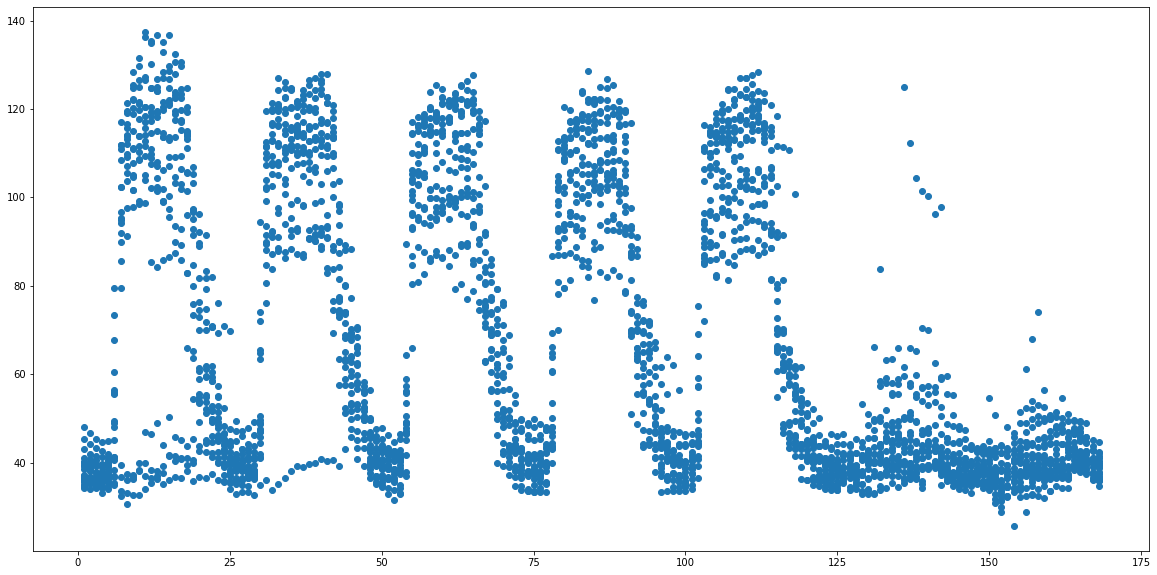

In [17]:
plt.scatter(df['hour_of_the_week'],df['Mean_Load'])

In [18]:
df.fillna(value = 0, inplace=True)

In [19]:
km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [20]:
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict

array([1, 1, 1, ..., 2, 2, 2])

In [21]:
# df[["hour_of_the_week","Mean_Load"]].to_numpy()

In [22]:
df['cluster1'] = y_predict
df.head()

,hour_of_the_week,Mean_Load,cluster1
0,133,37.835000,1
1,134,43.259552,1
2,135,40.673883,1
3,136,43.198733,1
4,137,46.881117,1


No handles with labels found to put in legend.


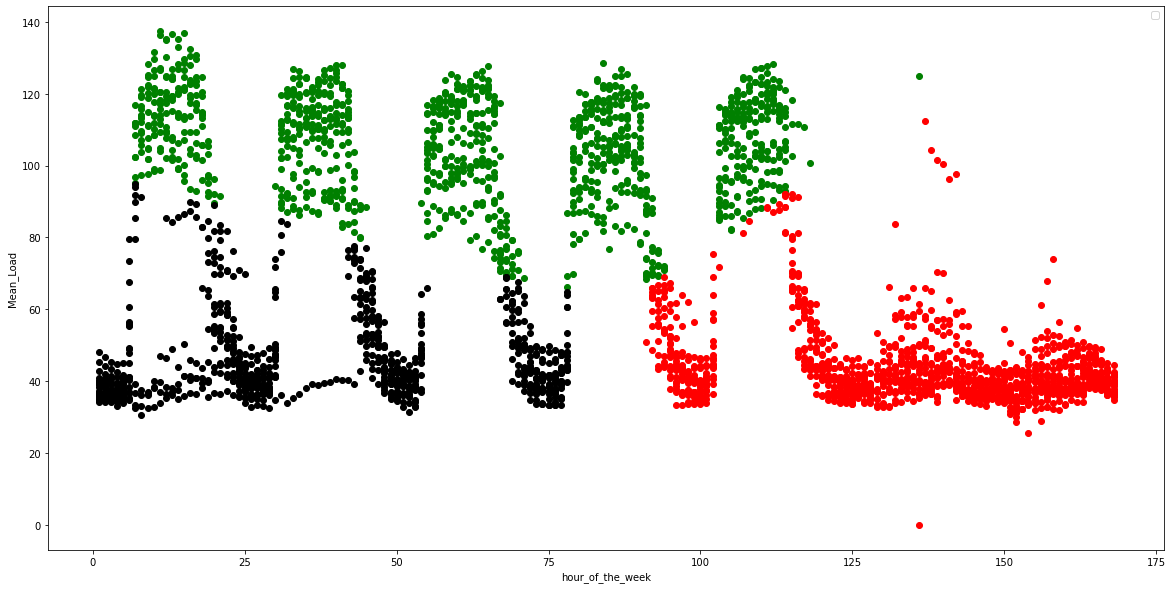

In [23]:
df1 = df[df.cluster1==0]
df2 = df[df.cluster1==1]
df3 = df[df.cluster1==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

### MinMax Scalarizing

In [24]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]
df.fillna(value=0, inplace=True)

scaler = MinMaxScaler()

# Fit and transform the scaler on the 'hour_of_the_week' and 'Mean_Load' columns
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# View the resulting dataframe with the scaled columns
df


,hour_of_the_week,Mean_Load
0,0.790419,0.275323
1,0.796407,0.314798
2,0.802395,0.295982
3,0.808383,0.314355
4,0.814371,0.341151
...,...,...
3271,0.257485,0.581870
3272,0.263473,0.561858
3273,0.269461,0.482813
3274,0.275449,0.417886


In [25]:
km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict

array([2, 2, 2, ..., 0, 0, 0])

In [26]:
km.cluster_centers_

array([[0.22699272, 0.33800602],
       [0.37228558, 0.77175752],
       [0.80267372, 0.31645899]])

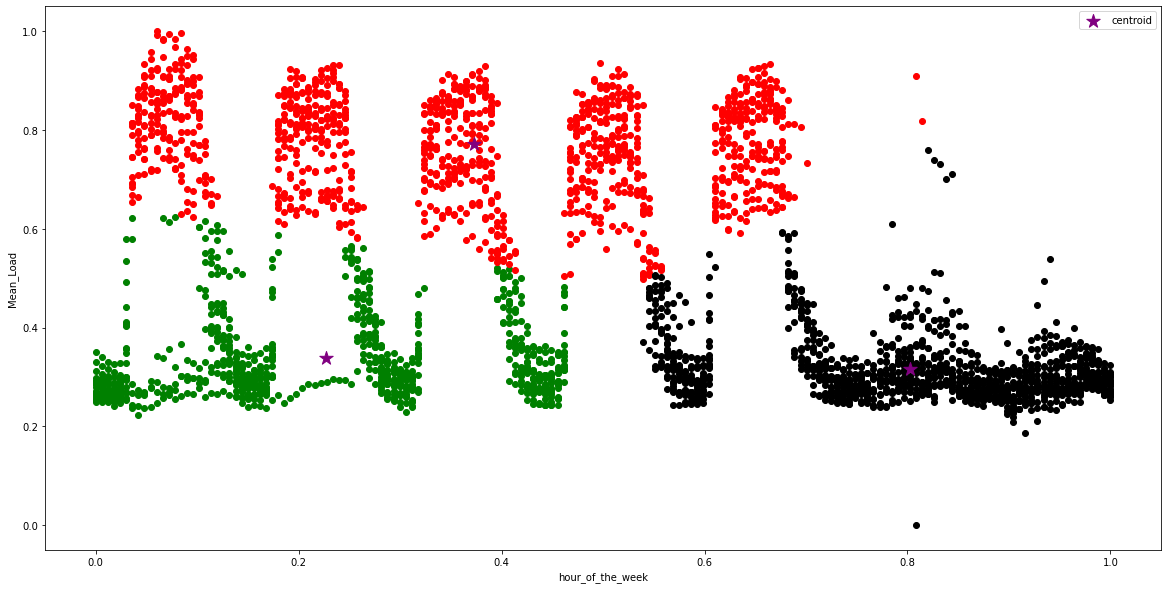

In [27]:
df['cluster2'] = y_predict
df1 = df[df.cluster2==0]
df2 = df[df.cluster2==1]
df3 = df[df.cluster2==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',s=marker_size, label='centroid')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

In [28]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['hour_of_the_week','Mean_Load']])
    sse.append(km.inertia_)

In [29]:
sse

[456.86510323145404,
 211.5767339084644,
 109.29929329694514,
 72.14899165568488,
 51.070671718376474,
 43.57647952916588,
 36.58457205035971,
 31.673057813968327,
 27.71923670076437]

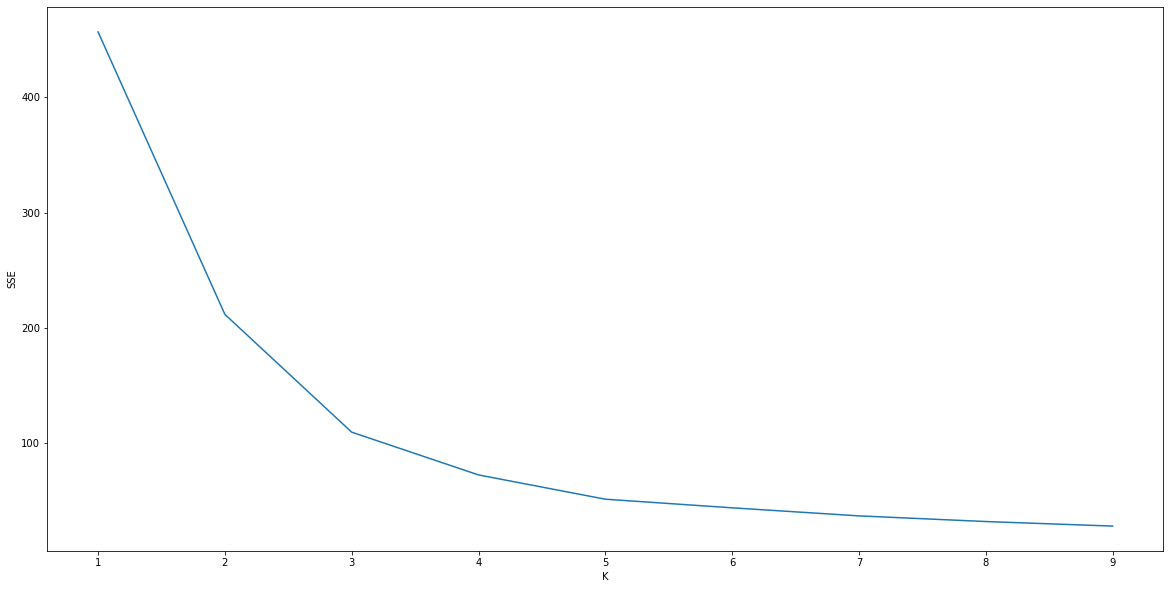

In [30]:
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

### Normalizer

In [31]:
import pandas as pd
from sklearn.preprocessing import Normalizer

df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]
df.fillna(value = 0, inplace=True)
scaler = Normalizer()

# Transform the scaler on the 'hour_of_the_week' and 'Mean_Load' columns
df = pd.DataFrame(scaler.transform(df), columns=df.columns)

# View the resulting dataframe with the scaled columns



In [32]:
km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict

array([1, 1, 1, ..., 0, 0, 0])

In [33]:
km.cluster_centers_

array([[0.65851848, 0.74112724],
       [0.94098442, 0.32412314],
       [0.25467826, 0.95645739]])

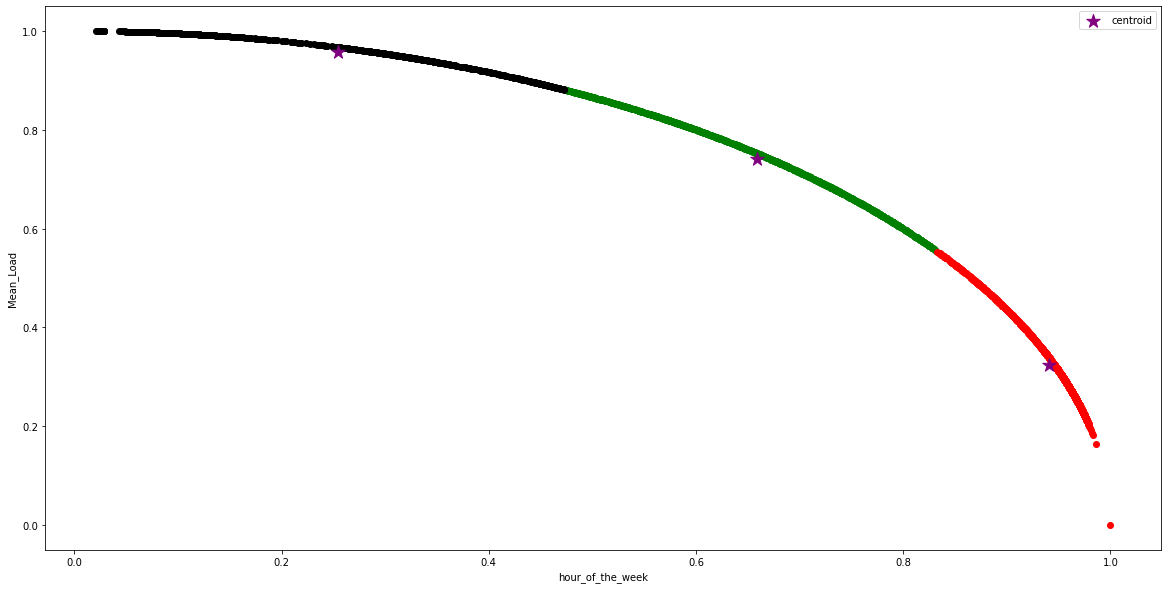

In [34]:
df['cluster2'] = y_predict
df1 = df[df.cluster2==0]
df2 = df[df.cluster2==1]
df3 = df[df.cluster2==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',s=marker_size,label='centroid')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

In [35]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['hour_of_the_week','Mean_Load']])
    sse.append(km.inertia_)

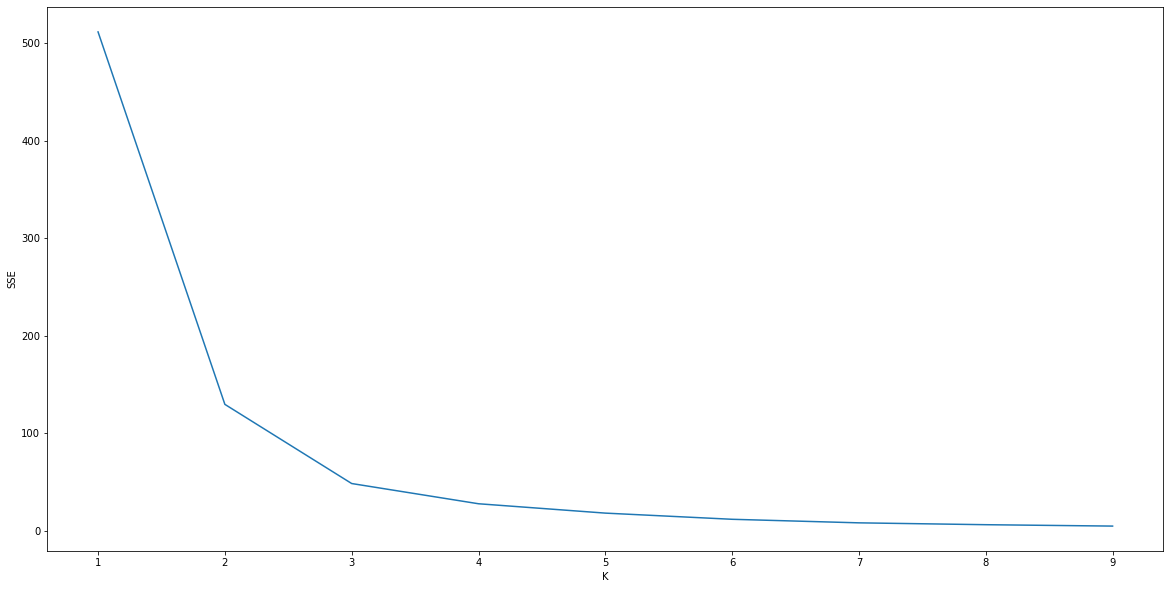

In [36]:
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

### Standardized Scalar

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]
df.fillna(value=0, inplace = True)
scaler = StandardScaler()

# Fit and transform the scaler on the 'hour_of_the_week' and 'Mean_Load' columns
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# View the resulting dataframe with the scaled columns
print(df)


      hour_of_the_week  Mean_Load
0             0.993930  -0.918685
1             1.014358  -0.748085
2             1.034787  -0.829403
3             1.055215  -0.749998
4             1.075644  -0.634188
...                ...        ...
3271         -0.824215   0.406150
3272         -0.803786   0.319662
3273         -0.783358  -0.021954
3274         -0.762929  -0.302557
3275         -0.742501  -0.332855

[3276 rows x 2 columns]


In [38]:
km = KMeans(n_clusters=3)
y_predict = km.fit_predict(df[['hour_of_the_week','Mean_Load']])
y_predict

array([0, 0, 0, ..., 2, 2, 2])

In [39]:
km.cluster_centers_

array([[ 1.02625714, -0.73921357],
       [-0.44304079,  1.23321124],
       [-0.91887991, -0.66328196]])

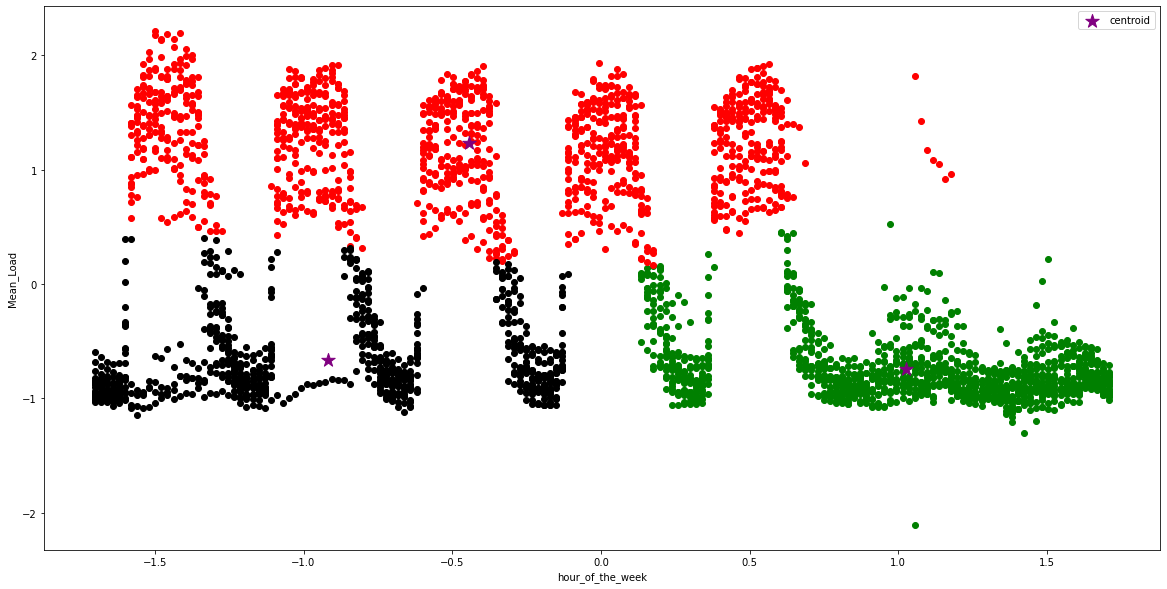

In [40]:
df['cluster2'] = y_predict
df1 = df[df.cluster2==0]
df2 = df[df.cluster2==1]
df3 = df[df.cluster2==2]

plt.scatter(df1.hour_of_the_week, df1['Mean_Load'], color='green')
plt.scatter(df2.hour_of_the_week, df2['Mean_Load'], color='red')
plt.scatter(df3.hour_of_the_week, df3['Mean_Load'], color='black')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',s=marker_size,label='centroid')

plt.xlabel('hour_of_the_week')
plt.ylabel('Mean_Load')
plt.legend()

In [41]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['hour_of_the_week','Mean_Load']])
    sse.append(km.inertia_)

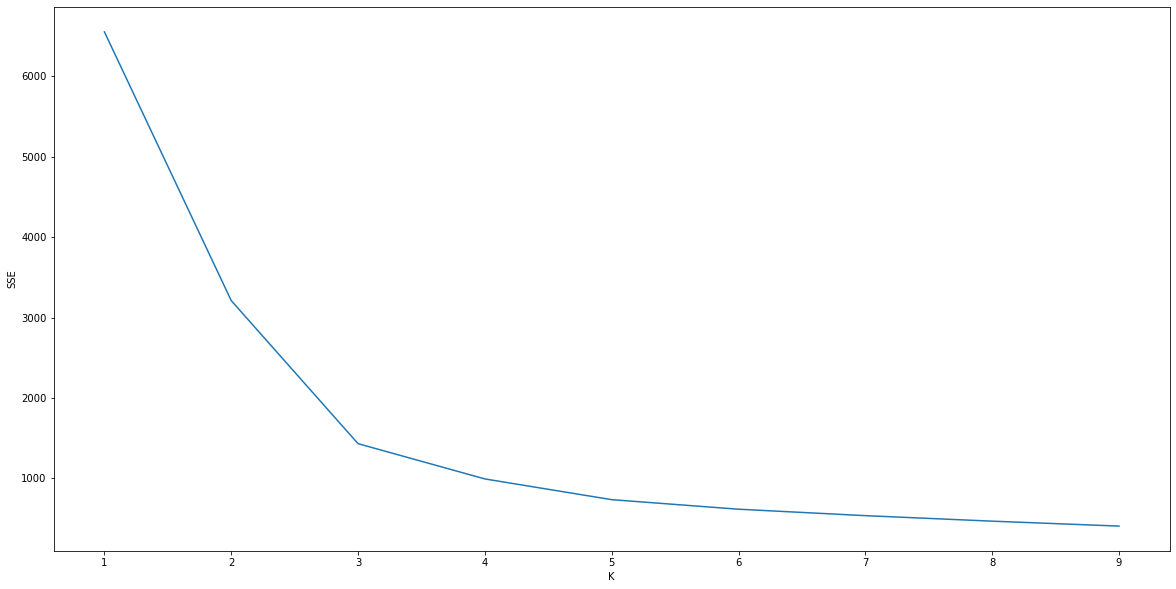

In [42]:
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(k_rng,sse)

In [43]:
df = df_hr_max_min_mean[['hour_of_the_week','Mean_Load']]

In [44]:
import pandas as pd



# Use the dropna method to return all rows with missing values
rows_with_NA = df[df.isna().any(axis=1)]

# View the resulting dataframe with rows containing missing values
print(rows_with_NA)


      hour_of_the_week  Mean_Load
3195               136        NaN


###### Check Silhoutte Scores

tends to zero (0 - 1)

###### Findings

Ways to cluster the time series data

- Agglomerative clustering: This type of clustering includes the distance matrix to cluster the time series data set.  
- Time series K-Means: It is a very basic way that can include euclidean, dynamic time warping, or soft dynamic time warping. 
- Kernel K-Means: This method is similar to the time series k-means but in it for clustering data, we rely on the kernel trick that mainly introduces a positive semidefinite.
- K-means DBA clustering: This type of clustering includes averaging strategy DTW barycenter averaging for clustering the time series data. 
- K-Medoid clustering: This type of clustering includes a distance matrix to perform k-medoid clustering. 


[Other time series classification model](https://github.com/Tobi-DataDetective/Energy_Load_Profile_Classification/blob/main/paper1.pdf)
 <br>
[Kaggle](https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering)

ML Models For Time-Series Forecasting
 

* ARIMA Model: As mentioned in the above section, it is a combination of three different models itself, AR, MA and I, where
   - “AR” reflects the evolving variable of interest is regressed on its own prior values,
   - “MA” infers that the regression error is the linear combination of error terms values happened at various stages of time priorly, and
   - “I” shows the data values are replaced by the difference between their values and the previous values.

* Combinedly “ARIMA” tries to fit the data into the model, and also ARIMA depends on the accuracy over a broad width of time series.

 

* ARCH/GARCH Model: Being the extended model of its common version GARCH, Autoregressive Conditional Heteroscedasticity (ARCH) is the most volatile model for time series forecasting, and are well trained for catching dynamic variations of volatility from time series.
 

* Vector Autoregressive Model or VAR model:  It gives the independencies between various time-series data which as a generalization of the Univariate Autoregression Model.
 

* LSTM: Long-short term memory(LSTM)is a deep learning model, it is a kind of Recurrent Neural Network(RNN) to read the sequence dependencies.
 

It enables us to handle long structures during training the dataset and creates predictions according to previous data.  

 

The blog ends here, we have discussed so far about time series analysis and its model, its role in financial analysis including various examples, and the impact of machine learning on time series along with applications.

 



2022-02-11 02:10:00  ====>  132  ====> Mean Load value / Load Class 

In [45]:
df

,hour_of_the_week,Mean_Load
0,133,37.835000
1,134,43.259552
2,135,40.673883
3,136,43.198733
4,137,46.881117
...,...,...
3271,44,79.960733
3272,45,77.210667
3273,46,66.348317
3274,47,57.426000
